# NAIP inference and similarity search with Clay v1
This notebook walks through Clay model v1 inference on NAIP (National Agriculture Imagery Program) data and similarity search. The workflow includes loading and preprocessing data from STAC, tiling the images and encoding metadata, generating embeddings and querying across them for similar representations. The NAIP data comes in annual composites. We are using data from one year within a sampled region in San Francisco, California.


In [ ]:
import sys
sys.path.append("..")

In [14]:
import os
import glob
import math
import boto3
import yaml
import random
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray  # noqa: F401
import torch
import stackstac
from pystac_client import Client
import pystac_client
from box import Box
import lancedb
from pathlib import Path
import shapely
from einops import rearrange
from torchvision.transforms import v2
from stacchip.processors.prechip import normalize_timestamp

from src.datamodule import ClayDataModule
from src.model_clay_v1 import ClayMAEModule


In [ ]:
# STAC API endpoint and platform details
STAC_API = "https://planetarycomputer.microsoft.com/api/stac/v1"
PLATFORM_NAME = "naip"

# Directory to save the downloaded data
save_dir = "./data_naip_test/ca/2020/sf/"
os.makedirs(save_dir, exist_ok=True)

YEAR = 2020

# STAC API search query
search_query = {
    "collections": [PLATFORM_NAME],
    "bbox": [-122.6, 37.6, -122.35, 37.85],  # Part of San Francisco, CA
    "datetime": f"{YEAR}-01-01T00:00:00Z/{YEAR+1}-01-01T00:00:00Z",
}

client = Client.open(STAC_API)
items = client.search(**search_query)

stackstac_datasets = []
granule_names = []

# Iterate over the granule names and fetch the corresponding StackSTAC data arrays
for item in items.get_all_items():
    assets = item.assets
    dataset = rioxarray.open_rasterio(item.assets["image"].href).sel(band=[1, 2, 3, 4])
    granule_name = item.assets["image"].href.split('/')[-1]
    stackstac_datasets.append(dataset)
    granule_names.append(granule_name)

Below are some functions we will rely on to prepare the data cubes, generate embeddings and plot subsets of the tiled images for visualization purposes.

In [3]:
def plot_rgb(stack):
    """
    Plot the RGB bands of the given stack.

    Parameters:
    stack (xarray.DataArray): The input data array containing band information.
    """
    stack.sel(band=[1, 2, 3]).plot.imshow(
        rgb="band", vmin=0, vmax=2000, col_wrap=6
    )
    plt.show()
    
def normalize_latlon(lat, lon):
    """
    Normalize latitude and longitude to a range between -1 and 1.

    Parameters:
    lat (float): Latitude value.
    lon (float): Longitude value.

    Returns:
    tuple: Normalized latitude and longitude values.
    """
    lat = lat * np.pi / 180
    lon = lon * np.pi / 180

    return (math.sin(lat), math.cos(lat)), (math.sin(lon), math.cos(lon))

def load_model(ckpt, device="cuda"):
    """
    Load a pretrained Clay model from a checkpoint.

    Parameters:
    ckpt (str): Path to the model checkpoint.
    device (str): Device to load the model onto (default is 'cuda').

    Returns:
    model: Loaded model.
    """
    torch.set_default_device(device)
    model = ClayMAEModule.load_from_checkpoint(
        ckpt, metadata_path="../configs/metadata.yaml", shuffle=False, mask_ratio=0
    )
    model.eval()
    return model.to(device)

def prep_datacube(stack, lat, lon, device):
    """
    Prepare a data cube for model input.

    Parameters:
    stack (xarray.DataArray): The input data stack.
    lat (float): Latitude value for the location.
    lon (float): Longitude value for the location.
    device (str): Device to load the data onto.

    Returns:
    dict: Prepared data cube with normalized values and embeddings.
    """
    platform = "naip"

    # Extract mean, std, and wavelengths from metadata
    metadata = Box(yaml.safe_load(open("../configs/metadata.yaml")))
    mean = []
    std = []
    waves = []
    for band in stack.band:
        mean.append(metadata[platform].bands.mean[str(band.values)])
        std.append(metadata[platform].bands.std[str(band.values)])
        waves.append(metadata[platform].bands.wavelength[str(band.values)])

    transform = v2.Compose(
        [
            v2.Normalize(mean=mean, std=std),
        ]
    )

    # Prep datetimes embedding
    datetimes = stack.time.values.astype("datetime64[s]").tolist()
    times = [normalize_timestamp(dat) for dat in datetimes]
    week_norm = [dat[0] for dat in times]
    hour_norm = [dat[1] for dat in times]

    # Prep lat/lon embedding
    latlons = [normalize_latlon(lat, lon)] * len(times)
    lat_norm = [dat[0] for dat in latlons]
    lon_norm = [dat[1] for dat in latlons]

    # Prep pixels
    pixels = torch.from_numpy(stack.data.astype(np.float32))
    pixels = transform(pixels)

    # Prepare additional information
    return {
        "pixels": pixels.to(device),
        "time": torch.tensor(
            np.hstack((week_norm, hour_norm)),
            dtype=torch.float32,
            device=device,
        ),
        "latlon": torch.tensor(
            np.hstack((lat_norm, lon_norm)), dtype=torch.float32, device=device
        ),
        "gsd": torch.tensor(stack.gsd.values, device=device),
        "waves": torch.tensor(waves, device=device),
    }

def generate_embeddings(model, datacube):
    """
    Generate embeddings from the model using the data cube.

    Parameters:
    model (ClayMAEModule): The pretrained model.
    datacube (dict): Prepared data cube.

    Returns:
    numpy.ndarray: Generated embeddings.
    """
    with torch.no_grad():
        unmsk_patch, unmsk_idx, msk_idx, msk_matrix = model.model.encoder(datacube)

    # The first embedding is the class token, which is the
    # overall single embedding. 
    return unmsk_patch[:, 0, :].cpu().numpy()

def tile_dataset(dataset, granule_name):
    """
    Tile dataset into 256x256 image chips and drop any excess border regions.

    Parameters:
    dataset (xarray.DataArray): Input dataset to be tiled.
    granule_name (str): Name of the granule.

    Returns:
    tuple: List of tiles and their corresponding names.
    """
    dataset = dataset.transpose("band", "y", "x")

    # Crop the dataset to remove excess border regions
    cropped_dataset = dataset.isel(x=slice(1, -1), y=slice(1, -1))

    # Determine the number of tiles in x and y dimensions
    num_x_tiles = cropped_dataset.x.size // 256
    num_y_tiles = cropped_dataset.y.size // 256

    # Iterate over each tile
    tiles = []
    tile_names = []
    for x_idx in range(num_x_tiles):
        for y_idx in range(num_y_tiles):
            # Calculate the coordinates for this tile
            x_start = x_idx * 256
            y_start = y_idx * 256
            x_end = x_start + 256
            y_end = y_start + 256

            # Extract the tile from the cropped dataset
            tile = cropped_dataset.isel(x=slice(x_start, x_end), y=slice(y_start, y_end))
            
            # Calculate the centroid
            centroid_x = (tile.x * tile).sum() / tile.sum()
            centroid_y = (tile.y * tile).sum() / tile.sum()
            
            lon = centroid_x.item()
            lat = centroid_y.item()

            tile = tile.assign_coords(band=['red','green','blue','nir'])
            tile_save = tile

            time_coord = xr.DataArray(['2020-01-01'], dims='time', name='time')
            tile = tile.expand_dims(time=[0])
            tile = tile.assign_coords(time=time_coord)

            gsd_coord = xr.DataArray([0.6], dims='gsd', name='gsd')
            tile = tile.expand_dims(gsd=[0])
            tile = tile.assign_coords(gsd=gsd_coord)

            tile_name = f"{granule_name[:-4]}_{x_idx}_{y_idx}.tif"

            tile_path = f"{save_dir}/{granule_name[:-4]}_{x_idx}_{y_idx}.tif"
            tile_save.rio.to_raster(tile_path)
            tiles.append(tile)
            tile_names.append(tile_name)
            
    return tiles, tile_names


In [ ]:
# Flag to control whether to make tiles or load existing ones
make_tiles = False

if make_tiles:
    tiles_ = []
    tile_names_ = []

    # Tile each dataset
    for dataset, granule_name in zip(stackstac_datasets, granule_names):
        tiles, tile_names = tile_dataset(dataset, granule_name)
        tiles_.append(tiles)
        tile_names_.append(tile_names)
    # Flatten sublists
    tiles__ = [tile for tile in tiles for tile_ in tiles_]
    tile_names__ = [tile for tile in tile_names for tile_ in tile_names_]
else:
    tiles__ = []
    tile_names__ = []
    for filename in os.listdir(save_dir):
        if filename.endswith(".tif"):  
            tile_names__.append(filename)
            file_path = os.path.join(save_dir, filename)
            data_array = rioxarray.open_rasterio(file_path)
            tiles__.append(data_array)

In [29]:
len(tiles__)

36024

In [120]:
outdir_embeddings = "./data_naip_test/ca/2020/sf_embeddings"
os.makedirs(outdir_embeddings, exist_ok=True)

### Load the trained Clay v1 model

In [ ]:
# Load the pretrained model
model = load_model(
    # ckpt="s3://clay-model-ckpt/v0.5.3/mae_v0.5.3_epoch-29_val-loss-0.3073.ckpt",
    # ckpt="../checkpoints/v0.5.3/mae_v0.5.3_epoch-08_val-loss-0.3150.ckpt",
    ckpt="s3://clay-model-ckpt/v0.5.7/mae_v0.5.7_epoch-13_val-loss-0.3098.ckpt",
    device="cuda",
)

### Generate embeddings

In [ ]:
embeddings = []
i = 0
for tile, fname in zip(tiles__, tile_names__):
    # Calculate the centroid
    centroid_x = (tile.x * tile).sum() / tile.sum()
    centroid_y = (tile.y * tile).sum() / tile.sum()
    
    lon = centroid_x.item()
    lat = centroid_y.item()
    
    datacube = prep_datacube(tile, lat, lon, model.device)
    embeddings_ = generate_embeddings(model, datacube)
    embeddings.append(embeddings_)

    date = tile.time
    data = {
        "source_url": str(fname[:-4]),
        "date": pd.to_datetime(arg=date, format="%Y-%m-%d").astype(
            dtype="date32[day][pyarrow]"
        ),
        "embeddings": [np.ascontiguousarray(embeddings_.squeeze())],
    }

    # Define the bounding box as a Polygon (xmin, ymin, xmax, ymax)
    box_ = tile.rio.bounds()
    box_emb = shapely.geometry.box(box_[0], box_[1], box_[2], box_[3])

    # Create the GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=[box_emb], crs=f"EPSG:{tile.rio.crs.to_epsg()}")

    # Reproject to WGS84 (lon/lat coordinates)
    gdf = gdf.to_crs(epsg=4326)

    outpath = (
        f"{outdir_embeddings}/"
        f"{fname[:-4]}.gpq"
    )
    gdf.to_parquet(path=outpath, compression="ZSTD", schema_version="1.0.0")
    print(
        f"Saved {len(gdf)} rows of embeddings of "
        f"shape {gdf.embeddings.iloc[0].shape} to {outpath}"
    )
    i += 1

In [124]:
embeddings[0].shape

(1, 768)

In [125]:
len(embeddings)

35720

### Run a similarity search to identify similar embeddings
We will select a random index to search with and plot the corresponding RGB images from the search results. 

In [126]:
# Connect to the embeddings database
db = lancedb.connect("embeddings")

In [127]:
# Data for DB table
data = []
# Dataframe to find overlaps within
gdfs = []
idx  = 0
for emb in glob.glob(f"{outdir_embeddings}/*.gpq"):
    gdf = gpd.read_parquet(emb)
    gdf["year"] = gdf.date.dt.year
    gdf["tile"] = gdf["source_url"]
    gdf["idx"] = idx
    gdf["box"] = [shapely.geometry.box(*geom.bounds) for geom in gdf.geometry]
    gdfs.append(gdf)

    for _, row in gdf.iterrows():
        data.append(
            {
                "vector": row["embeddings"],
                "path": row["source_url"],
                "tile": row["tile"],
                "date": row["date"],
                "year": int(row["year"]),
                "idx": row["idx"],
                "box": row["box"].bounds,
            }
        )
    idx += 1


In [128]:
# Combine patch level geodataframes into one
embeddings_gdf = pd.concat(gdfs, ignore_index=True)

In [129]:
# Drop existing table if any
db.drop_table("clay-v001")
db.table_names()

[]

In [ ]:
# Create a new table with the embeddings data
tbl = db.create_table("clay-v001", data=data, mode="overwrite")

In [131]:
# Select a random embedding for the search query
idx = random.randint(0, len(embeddings_gdf))
v = tbl.to_pandas().iloc[idx]["vector"]

In [133]:
# Perform the search
result = tbl.search(query=v).limit(10).to_pandas()

In [134]:
result.path

0    m_3712212_ne_10_060_20200524_20_42
1    m_3712212_ne_10_060_20200524_20_43
2    m_3712212_ne_10_060_20200524_19_41
3    m_3712212_ne_10_060_20200524_17_35
4     m_3712212_ne_10_060_20200524_3_21
5     m_3712212_ne_10_060_20200524_1_18
6    m_3712212_ne_10_060_20200524_13_32
7    m_3712212_ne_10_060_20200524_22_39
8    m_3712212_ne_10_060_20200524_34_39
9    m_3712212_ne_10_060_20200524_18_39
Name: path, dtype: object

In [ ]:
def plot(df, cols=10):
    """
    Plot the top similar images.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the search results.
    cols (int): Number of columns to display in the plot.
    """
    fig, axs = plt.subplots(1, cols, figsize=(20, 10))
    i = 0
    for ax, (_, row) in zip(axs.flatten(), df.iterrows()):
        row = df.iloc[i]
        path = row["path"]
        chip = rioxarray.open_rasterio(f"{save_dir}/{path}.tif").sel(band=['red', 'green', 'blue'])
        chip = chip.squeeze().transpose('x', 'y', 'band')
        ax.imshow(chip)
        ax.set_title(f"{row['idx']}")
        ax.set_axis_off()
        i += 1
    plt.tight_layout()
    fig.savefig("similar.png")

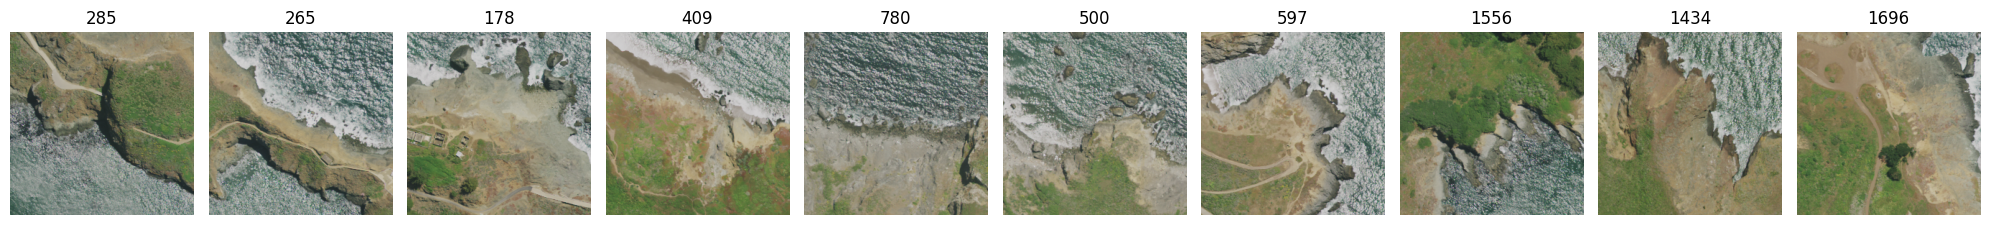

In [136]:
# Plot the top similar images
plot(result)

In [137]:
len(embeddings_gdf)

1786